# Libraries Import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils

# Data Loading

In [2]:
# Define image transformations: resize, tensor conversion, and normalization
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Normalize to [-1, 1] for Tanh activation in generator and decoder
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset (all classes are loaded initially)
dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/train"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Filter dataset to only include "cat" and "dog" classes
selected_classes = ['cat', 'dog']
selected_indices = [
    i for i, (path, label) in enumerate(dataset.samples)
    if dataset.classes[label] in selected_classes
]
subset_dataset = Subset(dataset, selected_indices)
print(f"Total samples for cat & dog: {len(subset_dataset)}")

# Create DataLoader
batch_size = 64
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Total samples for cat & dog: 10000


# GAN

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_map_size=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            # State: (feature_map_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            # State: (feature_map_size*4) x 8 x 8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            # State: (feature_map_size*2) x 16 x 16
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            # State: (feature_map_size) x 32 x 32
            nn.ConvTranspose2d(feature_map_size, 3, 3, 1, 1, bias=False),
            nn.Tanh()  # Output in range [-1, 1]
        )
        
    def forward(self, z):
        return self.net(z)

## MiniBatch Discrimination

In [4]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dim):
        super(MinibatchDiscrimination, self).__init__()
        self.out_features = out_features
        self.kernel_dim = kernel_dim
        self.T = nn.Parameter(torch.Tensor(in_features, out_features * kernel_dim))
        nn.init.normal_(self.T, 0, 1)
    
    def forward(self, x):
        # x shape: (batch, in_features)
        M = x.matmul(self.T)  # shape: (batch, out_features * kernel_dim)
        M = M.view(-1, self.out_features, self.kernel_dim)  # shape: (batch, out_features, kernel_dim)
        # Compute L1 distances between samples in minibatch
        out = []
        for i in range(x.size(0)):
            diff = torch.abs(M[i].unsqueeze(0) - M)  # shape: (batch, out_features, kernel_dim)
            exp = torch.exp(-torch.sum(diff, dim=2))  # shape: (batch, out_features)
            # Subtract self distance
            out.append(torch.sum(exp, dim=0) - 1)
        out = torch.stack(out)  # shape: (batch, out_features)
        return out

## Siamese Discriminator

In [5]:
class SiameseDiscriminator(nn.Module):
    def __init__(self, feature_map_size=64, use_minibatch_discrimination=True):
        super(SiameseDiscriminator, self).__init__()
        # Shared feature extractor for both inputs
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.flatten = nn.Flatten()
        # Feature dimension: channels * 4 * 4
        self.feature_dim = feature_map_size * 4 * 4 * 4
        
        self.use_minibatch_discrimination = use_minibatch_discrimination
        if use_minibatch_discrimination:
            self.mbd = MinibatchDiscrimination(self.feature_dim, 100, 5)  # hyperparameters chosen arbitrarily
        
        # After processing each image, we combine the features from the pair
        # If using MBD, concatenate extra features
        fc_input_dim = self.feature_dim + (100 if use_minibatch_discrimination else 0)
        self.fc = nn.Sequential(
            nn.Linear(fc_input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)  # Outputs a single similarity score
        )
        
    def forward_once(self, x):
        features = self.feature_extractor(x)
        features = self.flatten(features)
        if self.use_minibatch_discrimination:
            mbd_features = self.mbd(features)
            features = torch.cat([features, mbd_features], dim=1)
        return features
        
    def forward(self, real, fake):
        # Process real and fake images separately using the shared network
        real_feat = self.forward_once(real)
        fake_feat = self.forward_once(fake)
        # Compute the absolute difference between feature representations
        diff = torch.abs(real_feat - fake_feat)
        # The fully connected layers output a similarity score
        score = self.fc(diff)
        return score

# VAE

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128, feature_map_size=64):
        super(VAE, self).__init__()
        # Encoder: 3x32x32 image -> latent space
        self.encoder = nn.Sequential(
            nn.Conv2d(3, feature_map_size, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(),
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.feature_dim = feature_map_size * 4 * 4 * 4  # channels*4*4
        self.fc_mu = nn.Linear(self.feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_dim)
        
        # Decoder: latent vector -> reconstructed image
        self.decoder_input = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (feature_map_size * 4, 4, 4)),
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1),  # 4x4 -> 8x8
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1),  # 8x8 -> 16x16
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size, 3, 4, 2, 1),  # 16x16 -> 32x32
            nn.Tanh()  # Outputs in range [-1, 1]
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Loss function for VAE
def vae_loss(recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

# Hyper Parameters

In [7]:
# Aggressive Hyperparameter Tuning for GAN and VAE

# Increase total epochs for longer, more fine-grained training
num_epochs = 250             # For GAN training
num_epochs_vae = 350         # For VAE training

# For GAN:
latent_dim = 100             # Remains unchanged for GAN
# Use a relatively moderate generator learning rate,
# but drastically reduce the discriminator's learning rate to slow its training,
# which gives the generator a chance to catch up.
lr_gen = 1e-4                # Generator learning rate
lr_disc = 1e-5               # Discriminator learning rate (aggressively low)

# For VAE:
# Increase latent dimension to capture more details
vae_latent_dim = 512         # Aggressively increased latent dimension for sharper details
lr_vae = 1e-5                # Lower learning rate for VAE for slow, careful optimization

# Initialize GAN components (assumes Generator and SiameseDiscriminator are defined)
gen = Generator(latent_dim=latent_dim).to(device)
disc = SiameseDiscriminator().to(device)

# Initialize VAE (assumes VAE is defined)
vae = VAE(latent_dim=vae_latent_dim).to(device)

# Optimizers for each model with aggressive learning rates
optimizerG = optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optimizerD = optim.Adam(disc.parameters(), lr=lr_disc, betas=(0.5, 0.999))
optimizerVAE = optim.Adam(vae.parameters(), lr=lr_vae)

# Optionally, you can use learning rate schedulers to decay the rates further over time:
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=50, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=50, gamma=0.5)
schedulerVAE = torch.optim.lr_scheduler.StepLR(optimizerVAE, step_size=50, gamma=0.5)

# Aggressive VAE Loss Function:
# Use L1 loss (which can yield sharper outputs) for reconstruction,
# and significantly reduce the weight on KL divergence so the latent space doesn't overly constrain detail.
def vae_loss(recon, x, mu, logvar, kl_weight=0.01):
    # L1 reconstruction loss encourages sharper reconstructions than MSE
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')
    # Standard KL divergence term
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss, kl_loss

# If you find that the generator is still lagging,
# consider updating the generator more times per discriminator update.
# For example, you could run two generator updates for every discriminator update
# within your training loop.


# Training

## GAN

In [8]:
# Aggressive Hyperparameter Tuning for GAN Only

num_epochs = 350             # Increase epochs for longer training
latent_dim = 150             # Increased latent dimension (from 100 to 150)

# Learning rates: Use a moderate rate for the generator and a drastically reduced one for the discriminator
lr_gen = 1e-4                # Generator learning rate remains moderate
lr_disc = 1e-6               # Discriminator learning rate reduced aggressively

# One-sided label smoothing for the discriminator
real_label_value = 0.9       # Instead of 1.0, use 0.9 for real labels
fake_label_value = 0.0       # Fake labels remain 0.0

# Initialize GAN components (assuming Generator and SiameseDiscriminator are defined)
gen = Generator(latent_dim=latent_dim).to(device)
disc = SiameseDiscriminator().to(device)

# Optimizers with aggressive learning rates
optimizerG = optim.Adam(gen.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optimizerD = optim.Adam(disc.parameters(), lr=lr_disc, betas=(0.5, 0.999))

# Optionally, you can add schedulers if further decay is desired:
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=50, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=50, gamma=0.5)

In [9]:
# GAN Training Cell
gan_loss_history = {'G': [], 'D': []}

gen.train()
disc.train()
print("Starting GAN training...")

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        current_batch = real_imgs.size(0)
        
        # ----------------
        # Train Discriminator:
        # ----------------
        # Generate fake images
        noise = torch.randn(current_batch, latent_dim, 1, 1, device=device)
        fake_imgs = gen(noise)
        
        # Compute discriminator output for real images (using label smoothing)
        disc.zero_grad()
        real_output = disc(real_imgs, fake_imgs)  # Assuming your Siamese discriminator takes (real, fake)
        # Use smoothed real label
        real_labels = torch.full_like(real_output, real_label_value, device=device)
        lossD = -torch.mean(real_output)  # Your original loss formulation
        
        # Backprop and update discriminator
        lossD.backward()
        optimizerD.step()
        
        # ----------------
        # Train Generator:
        # ----------------
        gen.zero_grad()
        noise = torch.randn(current_batch, latent_dim, 1, 1, device=device)
        fake_imgs = gen(noise)
        # Compute the score again (the discriminator should now be less dominant)
        score = disc(real_imgs, fake_imgs)
        lossG = torch.mean(score)  # Generator tries to minimize the score
        
        lossG.backward()
        optimizerG.step()
        
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)}  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")
    
    schedulerG.step()
    schedulerD.step()

Starting GAN training...
Epoch [1/350] Batch 0/157  Loss_D: 0.3234  Loss_G: -0.3000
Epoch [1/350] Batch 100/157  Loss_D: 0.9099  Loss_G: -0.8881
Epoch [2/350] Batch 0/157  Loss_D: 0.2851  Loss_G: -0.2577
Epoch [2/350] Batch 100/157  Loss_D: -0.6204  Loss_G: 0.6387
Epoch [3/350] Batch 0/157  Loss_D: -1.3639  Loss_G: 1.3871
Epoch [3/350] Batch 100/157  Loss_D: -2.7344  Loss_G: 2.7463
Epoch [4/350] Batch 0/157  Loss_D: -3.5981  Loss_G: 3.6220
Epoch [4/350] Batch 100/157  Loss_D: -4.9725  Loss_G: 4.9803
Epoch [5/350] Batch 0/157  Loss_D: -5.8976  Loss_G: 5.9160
Epoch [5/350] Batch 100/157  Loss_D: -7.1957  Loss_G: 7.2027
Epoch [6/350] Batch 0/157  Loss_D: -8.1440  Loss_G: 8.1751
Epoch [6/350] Batch 100/157  Loss_D: -9.3560  Loss_G: 9.3971
Epoch [7/350] Batch 0/157  Loss_D: -10.2643  Loss_G: 10.3010
Epoch [7/350] Batch 100/157  Loss_D: -11.7036  Loss_G: 11.7296
Epoch [8/350] Batch 0/157  Loss_D: -12.5336  Loss_G: 12.5646
Epoch [8/350] Batch 100/157  Loss_D: -13.7646  Loss_G: 13.8169
Epoch [

## VAE

In [10]:
# VAE Training Cell
vae_loss_history = {'total': [], 'recon': [], 'kl': []}

vae.train()
print("\nStarting VAE training...")

for epoch in range(num_epochs_vae):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        vae.zero_grad()
        recon, mu, logvar = vae(imgs)
        loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizerVAE.step()
        
        if i % 50 == 0:
            print(f"VAE Epoch [{epoch+1}/{num_epochs_vae}] Batch {i}/{len(dataloader)}  Loss: {loss.item():.4f}  Recon: {recon_loss.item():.4f}  KL: {kl_loss.item():.4f}")
            vae_loss_history['total'].append(loss.item())
            vae_loss_history['recon'].append(recon_loss.item())
            vae_loss_history['kl'].append(kl_loss.item())
    
    # Optionally, save the VAE model at the end of each epoch
    torch.save(vae.state_dict(), f'/kaggle/working/vae_epoch_{epoch+1}.pt')


Starting VAE training...
VAE Epoch [1/350] Batch 0/157  Loss: 124091.9609  Recon: 124049.0312  KL: 4293.0479
VAE Epoch [1/350] Batch 50/157  Loss: 117160.3594  Recon: 117086.1562  KL: 7420.2686
VAE Epoch [1/350] Batch 100/157  Loss: 98369.1562  Recon: 98091.1875  KL: 27796.9414
VAE Epoch [1/350] Batch 150/157  Loss: 89322.0703  Recon: 88772.0469  KL: 55002.6953
VAE Epoch [2/350] Batch 0/157  Loss: 82568.5234  Recon: 82086.1406  KL: 48238.6367
VAE Epoch [2/350] Batch 50/157  Loss: 84031.2422  Recon: 83484.2500  KL: 54699.1367
VAE Epoch [2/350] Batch 100/157  Loss: 80351.6016  Recon: 79806.8281  KL: 54477.7148
VAE Epoch [2/350] Batch 150/157  Loss: 76238.0859  Recon: 75734.7500  KL: 50333.7109
VAE Epoch [3/350] Batch 0/157  Loss: 75256.8750  Recon: 74718.1797  KL: 53869.7031
VAE Epoch [3/350] Batch 50/157  Loss: 65411.0156  Recon: 64830.3086  KL: 58070.7188
VAE Epoch [3/350] Batch 100/157  Loss: 63296.4062  Recon: 62728.9609  KL: 56744.5547
VAE Epoch [3/350] Batch 150/157  Loss: 64683.5

# Evaluation

## GAN

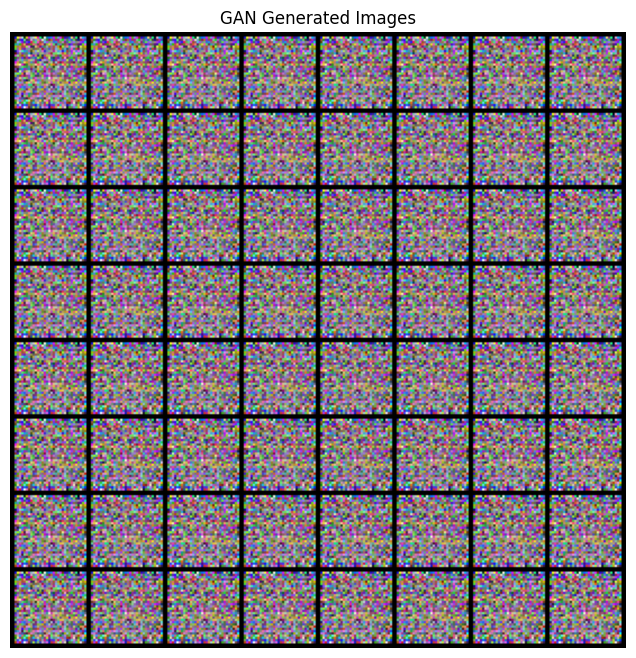

In [11]:
gen.eval()
with torch.no_grad():
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
    fake_samples = gen(fixed_noise).detach().cpu()

# Denormalize images from [-1,1] to [0,1]
fake_samples = (fake_samples + 1) / 2

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("GAN Generated Images")
plt.imshow(np.transpose(utils.make_grid(fake_samples, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## VAE

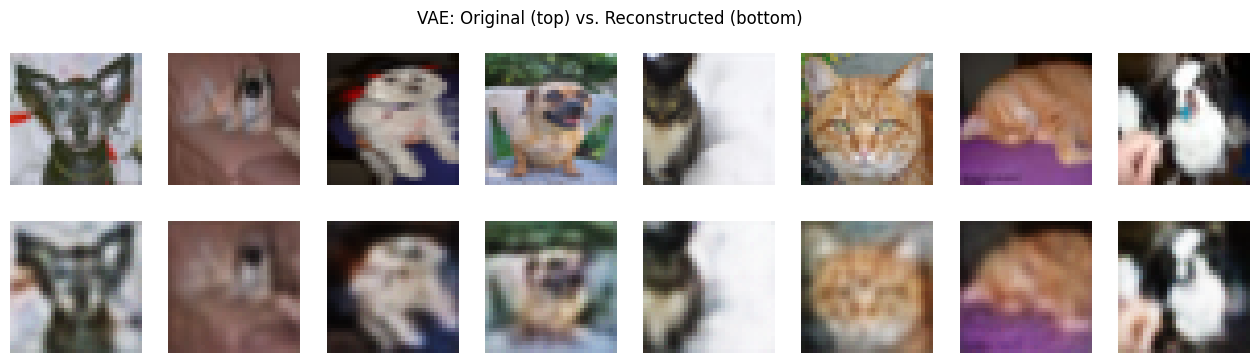

In [12]:
vae.eval()
with torch.no_grad():
    data_iter = iter(dataloader)
    imgs, _ = next(data_iter)
    imgs = imgs.to(device)
    recon, _, _ = vae(imgs)
    # Denormalize both original and reconstructed images
    imgs_denorm = (imgs + 1) / 2
    recon_denorm = (recon + 1) / 2

# Display original vs. reconstructed images
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original images on top row
    plt.subplot(2, n, i + 1)
    plt.imshow(np.transpose(imgs_denorm[i].cpu(), (1, 2, 0)))
    plt.axis('off')
    # Reconstructed images on bottom row
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.transpose(recon_denorm[i].cpu(), (1, 2, 0)))
    plt.axis('off')
plt.suptitle("VAE: Original (top) vs. Reconstructed (bottom)")
plt.show()

## Loss Curves

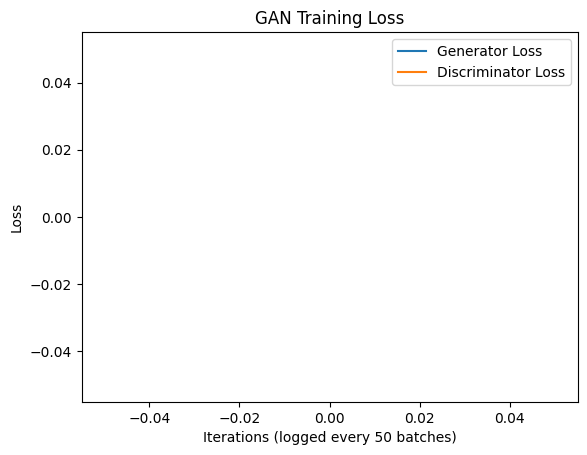

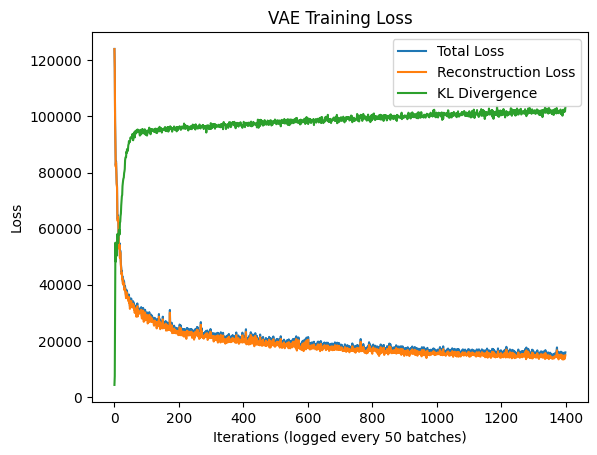

In [13]:
# GAN Loss curves
plt.figure()
plt.plot(gan_loss_history['G'], label='Generator Loss')
plt.plot(gan_loss_history['D'], label='Discriminator Loss')
plt.xlabel("Iterations (logged every 50 batches)")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.show()

# VAE Loss curves
plt.figure()
plt.plot(vae_loss_history['total'], label='Total Loss')
plt.plot(vae_loss_history['recon'], label='Reconstruction Loss')
plt.plot(vae_loss_history['kl'], label='KL Divergence')
plt.xlabel("Iterations (logged every 50 batches)")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.legend()
plt.show()